# Graph Classification - PROTEINS dataset

This notebook implements [Lightning Data Module](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for binary graph classification.

* Data source: PROTEINS benchmark dataset from [TU Dortmund](https://chrsmrrs.github.io/datasets/docs/datasets/)
* Task: classifying a type of protein: *enzyme* or *non-enzyme*

In [1]:
import torch
import torch_geometric as geom
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from lightning import LightningDataModule

## About the data

In [2]:
# setup dataset path
DATASET_PATH = '../data/'

# load the dataset
ds = geom.datasets.TUDataset(root=DATASET_PATH, name="PROTEINS")
ds

PROTEINS(1113)

In [3]:
# the number of graphs
len(ds)

1113

In [4]:
# In the data, all graphs are combined (concatenated) into one tensor. 
# Each node has a label from 3 classes implemented as a one-hot vector feature.
ds.data

/data/apps/miniconda3/envs/qpgcnn/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[43471, 3], edge_index=[2, 162088], y=[1113])

In [5]:
# To get a specific graph, use indices. E.g. to get the 5th graph
ds[4]

Data(edge_index=[2, 42], x=[11, 3], y=[1])

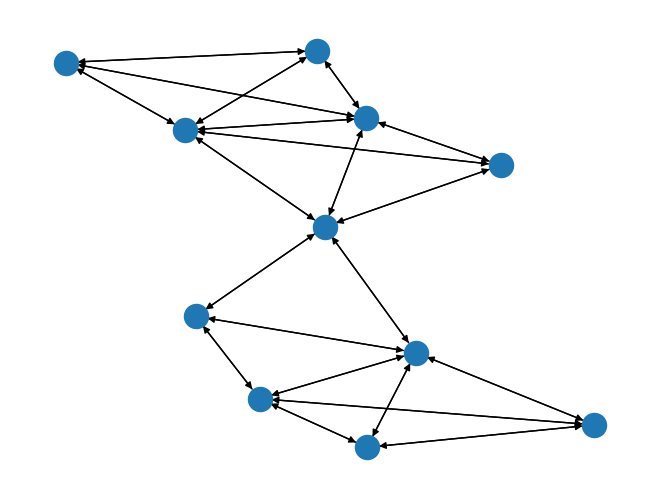

In [6]:
nx.draw(geom.utils.to_networkx(ds[4]))

In [7]:
ds[923]

Data(edge_index=[2, 172], x=[36, 3], y=[1])

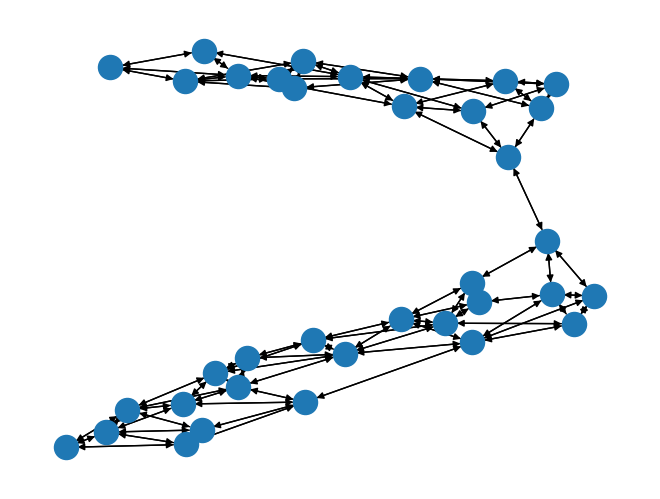

In [8]:
nx.draw(geom.utils.to_networkx(ds[923]))

In [9]:
# y is binary
# we can check if the data is balanced by calculating its mean (should be in the range of 0.5)
ds.y.float().mean().item()

0.4043126702308655

### Splitting

In [22]:
torch.manual_seed(42)
ds.shuffle()

# split 60/30/10 for train/vaiidation/test
train_set, val_set, test_set = torch.utils.data.random_split(ds, [0.6, 0.3, 0.1])

### Batching

There is a problem to do batching because the structure of each graph is different. They may have different nodes and edges.

Torch geometric can view *N* graphs in a batch as a single large graph by concatenating node and edge list. *Since there is no edge between different graphs, running GNN layers on this large graph gives us the same output as running GNN on each graph separately*.

Visually, this can be seen as follows:

![](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/torch_geometric_stacking_graphs.png)

In [25]:
# torch_geometric has implemented this as follows
train_loader = geom.loader.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = geom.loader.DataLoader(val_set, batch_size=64) 
test_loader = geom.loader.DataLoader(test_set, batch_size=64)

In [26]:
# test loading batches
batch = next(iter(test_loader))

# we have 38 graphs in our batch
batch

DataBatch(edge_index=[2, 8638], x=[2267, 3], y=[64], batch=[2267], ptr=[65])

## PROTEINS Data Module

In [41]:
# %load -r43: ../src/data/proteins_datamodule.py
class ProteinsDataModule(LightningDataModule):
    """`LightningDataModule` for the PROTEINS dataset from torch.

    The PROTEINS dataset consists of 1,113 protein molecules defined by the TUDataset.

    Read the docs:
        https://chrsmrrs.github.io/datasets/docs/datasets/
        https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.TUDataset.html

    Some information about the PROTEINS dataset:
    * Features for each node is a 3-element one-hot vectors
    * There are two types of molecule: enzyme (y=1) and non-enzyme (y=0)
    * The common task is binary graph classification
    """
    def __init__(self,
                 data_dir: str,
                 data_split: list) -> None:
        """Initialise the object.

        :param data_dir: a folder to save the data.
        :param data_split: [train, val, test] fractional split; sum must be 1.
        """
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        # initialise the dataset
        self.train_data = None
        self.val_data = None
        self.test_data = None

    def prepare_data(self) -> None:
        """Download the data (if necessary), then split."""
        ds = geom.datasets.TUDataset(root=self.hparams.data_dir, name="PROTEINS")

        # random split
        self.train_data, self.val_data, self.test_data = torch.utils.data.random_split(ds, self.hparams.data_split)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_data, batch_size=1)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_data, batch_size=1)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_data, batch_size=1)


### Configuration file

In [42]:
# %load ../configs/data/proteins.yaml
_target_: src.data.proteins_datamodule.ProteinsDataModule
data_dir: ${paths.data_dir}
data_split: [0.6, 0.3, 0.1]
batch_size: 64
num_workers: 0
pin_memory: False


## GCN Lightning Module

For this graph-level classification task, the network consists of $N$ layers of graph network modules and the last layer is a linear layer.